In [2]:

import os
import numpy as np
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai
    
!pip install -U duckduckgo_search   
from duckduckgo_search import ddg_images
from fastcore.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.28.2
    Uninstalling requests-2.28.2:
      Successfully uninstalled requests-2.28.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.2 requires requests<2.29,>=2.24.0, but you have requests 2.30.0 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 which is incomp

now lets defin the function thats going to find us an image

In [3]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
urls = search_images('building', max_images=1)
urls[0]

Searching for 'building'


'http://images.adsttc.com/media/images/53a8/119d/c07a/80c1/1200/00d8/large_jpg/537b7545c07a8021210000c2_shard-wins-emporis-skyscraper-award_4_cayan_tower__copyright_tim_griffith_som_b.jpg?1403523432'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


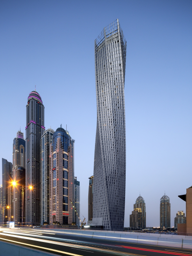

In [5]:
from fastdownload import download_url
dest = 'buildings.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'house photos'


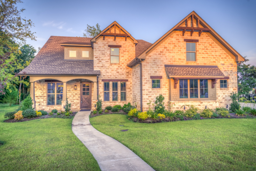

In [6]:
download_url(search_images('house photos', max_images=1)[0], 'house.jpg', show_progress=False)
Image.open('house.jpg').to_thumb(256,256)

In [7]:
searches = 'building','house'
path = Path('building_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'building photo'
Searching for 'building sun photo'
Searching for 'building shade photo'
Searching for 'house photo'
Searching for 'house sun photo'
Searching for 'house shade photo'


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

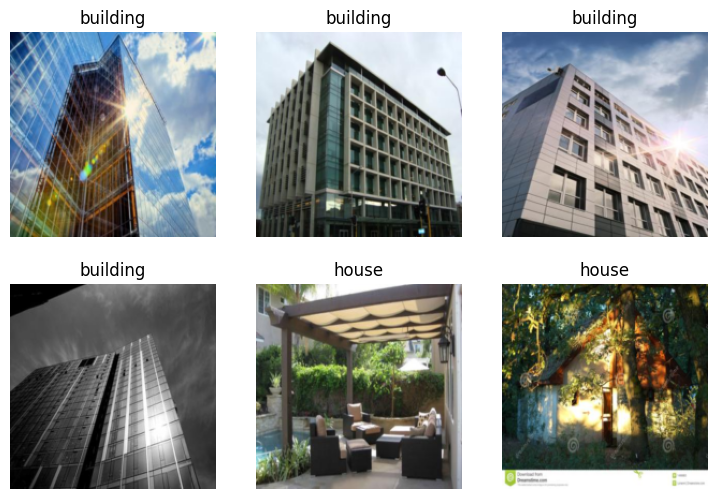

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, models.resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.275635,0.698785,0.272727,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.534115,0.207852,0.060606,00:24
1,0.358379,0.187238,0.090909,00:24
2,0.278800,0.182643,0.090909,00:24


**now, lets see a the prediction for a house picture i took from the internet, searching in hebrew(it increases the probabillity the picture is not on the training set)**

This is a: house.
Probability it's a building: 0.0004


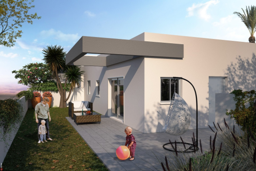

In [12]:


new_dest = 'NewHouse.jpg'
new_url = 'https://images1.ynet.co.il/PicServer5/2017/08/20/7980460/8.jpg'
download_url(new_url,new_dest,show_progress=False)

is_building,_,probs = learn.predict(PILImage.create('NewHouse.jpg'))
print(f"This is a: {is_building}.")
print(f"Probability it's a building: {probs[0]:.4f}")


Image.open(new_dest).to_thumb(256,256)